# Dependencies

In [ ]:
# Import necessary libraries
import random
import heapq
import numpy as np
import matplotlib.pyplot as plt

!pip -q install adjustText

# Constraints

In [ ]:
def in_bound(state):
    # Check if state is within bounds defined by 'm' and 'n'
    if state[0] < 0 or state[0] >= m or state[1] < 0 or state[1] >= n:
        return False  # Out of bounds
    return True   # Within bounds

In [ ]:
def in_constraint(agent, state, timestep, constraints):
    # Check if (agent, state, timestep) exists in constraints
    return any((a, s, t) == (agent, state, timestep) for (a, s, t) in constraints)

In [ ]:
def is_obstacle(state):
    # Check if the current 'state' is obstacle or not
    return state in obstacle

# Heuristic and Costs

In [ ]:
# heuristic
def heuristic(state, goal):
	# Calculate the Euclidean distance between 'state' and 'goal'
    return np.int64(np.sqrt(abs(state[0] - goal[0])**2 + abs(state[1] - goal[1])**2))

In [ ]:
# cost between two states
def cost(state1, state2):
    return 1  # Uniform cost for 2d grid

# Low Level Implementation

In [ ]:
# Get valid neighboring states for an agent
def get_neighbors(agent, state,  timestep, constraint_list):
    neighbors = []
    x, y = state

    # Iterate over possible moves (up, down, left, right)
    for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
        new_x, new_y = x + dx, y + dy

        # Check if the new position is within bounds, not an obstacle, and not constrained
        if in_bound((new_x, new_y)) and not is_obstacle((new_x, new_y)) and not in_constraint(agent, (new_x, new_y), timestep+1, constraint_list):
            neighbors.append((new_x, new_y))

    return neighbors

# A* Algorithm

In [ ]:
class Node:
    def __init__(self, state, parent=None, cost=0, heuristic=0):
        self.state = state  # current state
        self.parent = parent  # Parent node
        self.cost = cost  # Cost from the start node to current node
        self.heuristic = heuristic  # Heuristic cost from current node to the goal

    def __lt__(self, other):
        # Comparison method for priority queue
        return (self.cost + self.heuristic) < (other.cost + other.heuristic)

In [ ]:
def search(start, goal, agent, constraints):
    open_set = []  # Priority queue for open nodes
    closed_set = set()  # Set to keep track of visited nodes

    start_node = Node(state=start, cost=0, heuristic=heuristic(start, goal))
    heapq.heappush(open_set, (start_node, 0))  # Add start node to open set

    while open_set:
        # Extract the node with minimn fn value
        current_node, current_timestep = heapq.heappop(open_set)

        # goal condition
        if current_node.state == goal:
            path = []
            while current_node:
                path.append(current_node.state)
                current_node = current_node.parent
            return path[::-1]  # Return the path in reverse order

        # push current node to closed set
        closed_set.add(current_node.state)

        # generate the successor of the current node
        for neighbor_state in get_neighbors(agent, current_node.state, current_timestep, constraints):
            if neighbor_state in closed_set:
                continue

            tentative_cost = current_node.cost + cost(current_node.state, neighbor_state)

            neighbor_node = Node(state=neighbor_state, parent=current_node,
                                cost=tentative_cost, heuristic=heuristic(neighbor_state, goal))

            if neighbor_node not in open_set:
                heapq.heappush(open_set, (neighbor_node, current_timestep+1))  # Add neighbor to open set

    return None  # Return None if no path found

In [ ]:
# find path from start to destination
def find_path(start, desti, constraintList):
    path = []  # Initialize an empty list to store paths

    # Iterate over pairs of start and destination points
    for idx, (strt, goal) in enumerate(zip(start, desti)):
        sub_path = search(strt, goal, idx, constraintList)  # Find a path from 'strt' to 'goal'

        path.append(sub_path)  # Append the sub-path to the path list

    return path  # Return the list of paths


# High Level Implementation

In [ ]:
# Total cost
def sum_of_individual_cost(path_array):
    cost = 0
    for path in path_array:
        cost = cost + len(path)
    return cost

In [ ]:
# find the conflict node
def validate(node):
    # Find the length of the longest path among all agents
    max_len = max(len(path) for path in node.solution)

    conflicts = []

    # Iterate over time steps
    for i in range(max_len):
        # Iterate over agents
        for j in range(k):
            # Check if the agent has a path at the current time step
            if i < len(node.solution[j]):
                # Compare the agent's position with other agents
                for l in range(j+1, k):
                    # Check if the other agent has a path at the current time step
                    if i < len(node.solution[l]) and node.solution[j][i] == node.solution[l][i]:
                        conflicts = [j, l, node.solution[j][i], i]
                        return conflicts  # Return the conflicts if found

    return None  # Return None if no conflicts were found


# Conflict Based Searching

In [ ]:
class STATE:
    def __init__(self):
        self.constraints = []  # Constraints (agent, vertex, timestep)
        self.solution = []  # List of optimal paths for each agent
        self.cost = 0  # Total cost

In [ ]:
def cbs(start, goal):
    # initialization
    root = STATE()
    root.constriants = []
    root.solution = find_path(start, goal, root.constraints)
    root.cost = sum_of_individual_cost(root.solution)

    # Defining the list to store the open and closed list
    open_set = [root]
    closed_set = set()

    while open_set:
        # extract the nodw with minimum cost
        p = min(open_set, key=lambda node: node.cost)
        open_set.remove(p)


        # Validate the paths in P until a conflict occurs
        conflict = validate(p)

        # Goal condition
        if conflict is None:
            return p.solution

        # Iterating over all conflicted agents
        for agent in conflict[:-2]:

            time = conflict[-1]   # time step of conflict
            state = conflict[-2] # the node of conflict

            # Creating a new node for each agent
            a = STATE()
            a.constraints.extend(p.constraints)
            a.constraints.append((agent, state, time))
            a.solution = find_path(start, goal, a.constraints)
            a.cost = sum_of_individual_cost(a.solution)

            if a.cost < float('inf') and tuple(a.constraints) not in closed_set:
                open_set.append(a)

    return None  # No solution found

# Testing

### Defining the necessary functions

In [ ]:
# defining the fuctions
def initialize(m, n, k, obs):
    # (m x n) ------> size of the grid
    # k       ------> number of agents
    # obs     ------> number of obstacles
    return m, n, k, obs

In [ ]:
# for finding the best path using CBS
def find_path_using_CBS(start, pick, drop, desti):
    # start ------> pick up location ---------> drop location --------> Destionation

    # calling the CBS for finding the best path
    start_pick = cbs(start, pick)
    pick_drop = cbs(pick, drop)
    drop_desti = cbs(drop, desti)

    # Merging all the route into one
    final_path = []

    for i in range(k):
        path = []
        path.extend(start_pick[i])
        path.extend(pick_drop[i])
        path.extend(drop_desti[i])

        final_path.append(path)

    return final_path

In [ ]:
# for plotting the path of each agent
def plot_path(path, labels, obstacles, agent, m, n):
    path_x = [point[0] for point in path]
    path_y = [point[1] for point in path]

    plt.figure(figsize=(n, m))
    plt.plot(path_x, path_y, linestyle='-', label = f'Agent: {agent}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Path for Agent {agent}')
    plt.grid(True)

    label_names = ['Start', 'Pick', 'Drop', 'Destination']
    color_names = ['red', 'purple', 'green', 'orange']

    for lbl, label_name, color_name in zip(labels, label_names, color_names):
        # ploting the labels like start point, pick up point, drop point, destination.
        plt.scatter(lbl[0], lbl[1], label = label_name, color=color_name, marker='o')
        # defining the annotation for te labels
        plt.annotate(label_name, (lbl[0], lbl[1]))


    # ploting the obstacles
    obstacle_x = [obs[0] for obs in obstacles]
    obstacle_y = [obs[1] for obs in obstacles]
    plt.scatter(obstacle_x, obstacle_y, label = 'Obstacles', color='black', marker='o')

    # Annotate each point with its coordinates
    for i, (x, y) in enumerate(zip(path_x, path_y)):
        plt.annotate(f'({x}, {y})', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    plt.legend()
    plt.show()

In [ ]:
# for plotting the path of all agent in one plot
from adjustText import adjust_text

def plot_all(paths, obstacles, m, n):

    plt.figure(figsize=(n, m))
    styles = ['-', '--', ':']
    marks = ['o', 'x', 's']

    # ploting the obstacles
    obstacle_x = [obs[0] for obs in obstacles]
    obstacle_y = [obs[1] for obs in obstacles]
    plt.scatter(obstacle_x, obstacle_y, label = 'Obstacles', color='black', marker='o')

    for idx, (path, mark, style) in enumerate(zip(paths, marks, styles)):
        path_x = [point[0] for point in path]
        path_y = [point[1] for point in path]
        plt.plot(path_x, path_y, marker=mark, linestyle=style, label = f'Agent {idx+1}')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Combined Path of agents')
    plt.grid(True)
    plt.legend()
    # Annotate each point with its coordinates
    texts = []
    for path in paths:
        path_x = [point[0] for point in path]
        path_y = [point[1] for point in path]
        for i, (x, y) in enumerate(zip(path_x, path_y)):
            label = f'{i}'
            texts.append(plt.text(x, y, label, ha='center', va='bottom'))

    # Use adjust_text to automatically adjust label positions
    adjust_text(texts, autoalign='xy', arrowprops=dict(arrowstyle='-', color='red'))

    plt.show()


## Case 1: Given problem

In [ ]:
# Initializing
m, n, k, obs = initialize(6, 17, 3, 5)

# Create an empty list to store constraints
constraint_list = []

In [ ]:
# Defining the starting points, obstacle, pick up location, drop location, destination for the given case
obstacle = [(0, 13), (2, 1), (2, 15), (4, 10), (5, 3)]

# each column represent the number of robots/agents
start = [(0, 0), (5, 9), (1, 7)]
pick = [(5, 0), (4, 6), (1, 12)]
drop = [(0, 8), (5, 5), (3, 15)]
desti = [(3, 12), (0, 10), (0, 5)]

print(f"start: {start}\npick: {pick}\ndrop: {drop}\ndesti: {desti}\nobstacles: {obstacle}")

start: [(0, 0), (5, 9), (1, 7)]
pick: [(5, 0), (4, 6), (1, 12)]
drop: [(0, 8), (5, 5), (3, 15)]
desti: [(3, 12), (0, 10), (0, 5)]
obstacles: [(0, 13), (2, 1), (2, 15), (4, 10), (5, 3)]


In [ ]:
# find path from start from start ------> pick up location ---->  drop locationn ------> destination
final_path = find_path_using_CBS(start, pick, drop, desti)

# printing path
print(f'Path for Agent 1:{final_path[0]}')
print(f'Path for Agent 2:{final_path[1]}')
print(f'Path for Agent 3:{final_path[2]}')

Path for Agent 1:[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 0), (4, 0), (4, 1), (4, 2), (4, 3), (3, 3), (3, 4), (3, 5), (2, 5), (2, 6), (2, 7), (1, 7), (1, 8), (0, 8), (0, 8), (0, 9), (0, 10), (1, 10), (1, 11), (2, 11), (3, 11), (3, 12)]
Path for Agent 2:[(5, 9), (5, 8), (4, 8), (4, 7), (4, 6), (4, 6), (5, 6), (5, 5), (5, 5), (5, 6), (4, 6), (4, 7), (3, 7), (2, 7), (1, 7), (1, 8), (1, 9), (1, 10), (0, 10)]
Path for Agent 3:[(1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 12), (2, 12), (2, 13), (2, 14), (3, 14), (3, 15), (3, 15), (3, 14), (3, 13), (3, 12), (3, 11), (3, 10), (3, 9), (3, 8), (3, 7), (2, 7), (2, 6), (1, 6), (0, 6), (0, 5)]


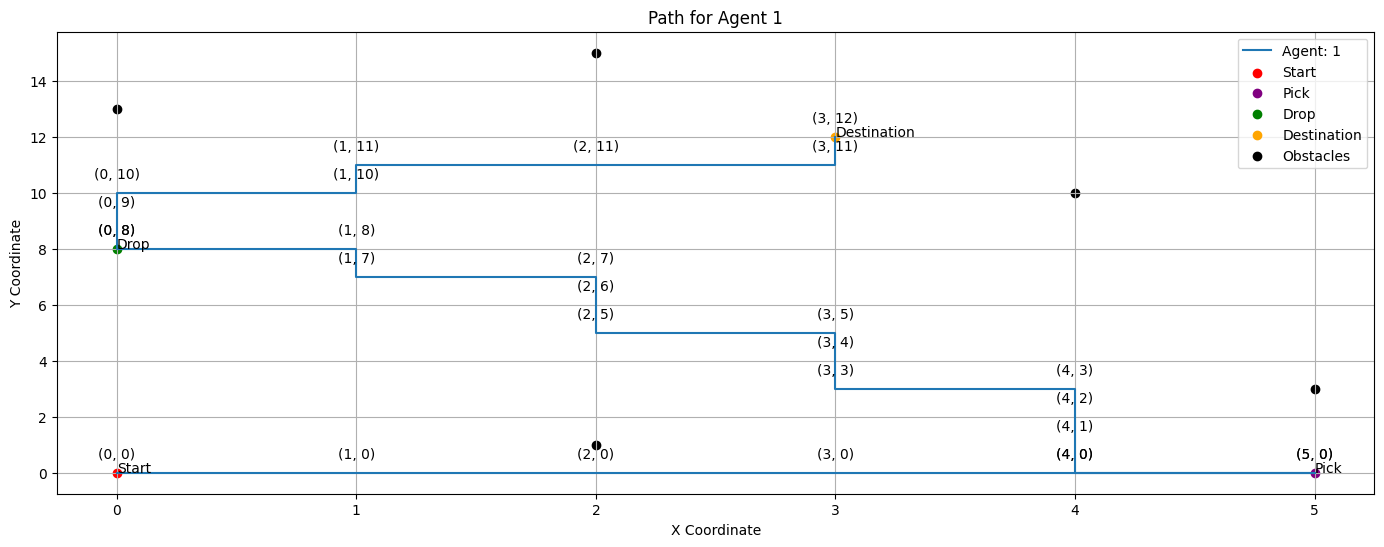

In [ ]:
# Path of Agent 1
plot_path(final_path[0], [start[0], pick[0], drop[0], desti[0]], obstacle, 1, m, n)

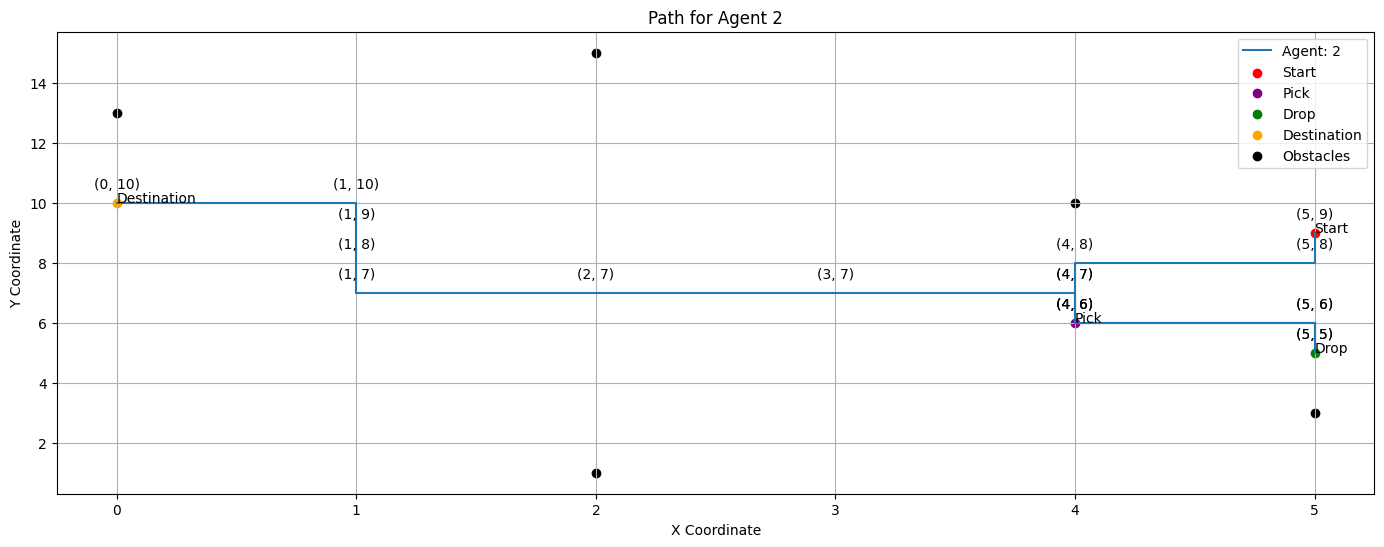

In [ ]:
# Path of Agent 2
plot_path(final_path[1], [start[1], pick[1], drop[1], desti[1]], obstacle, 2, m, n)

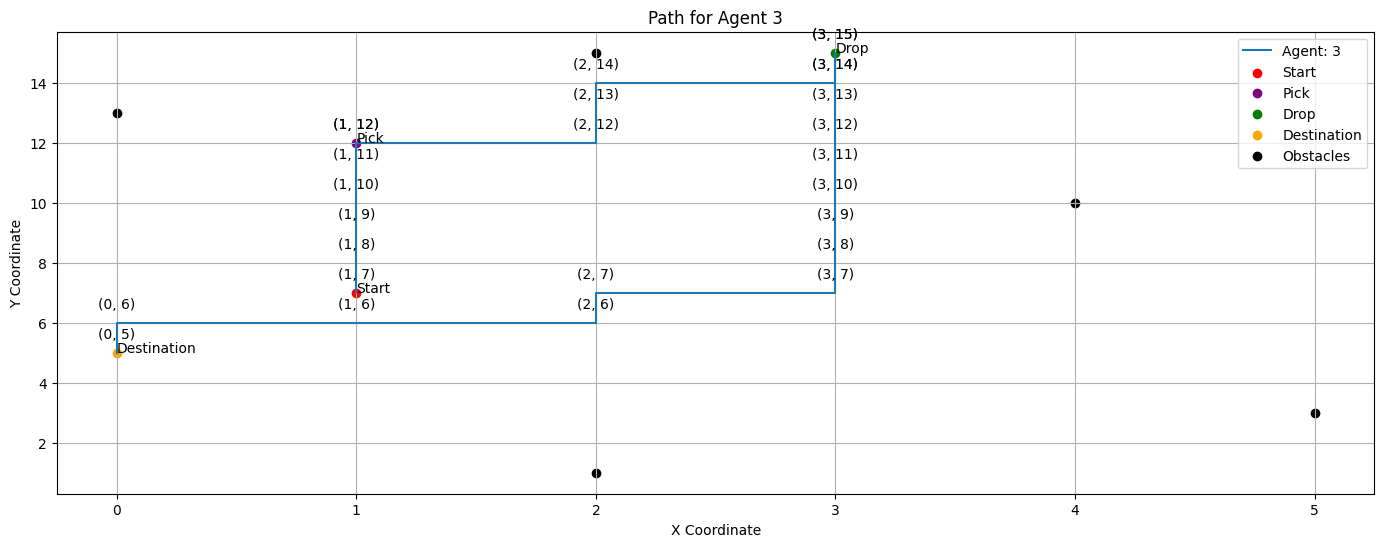

In [ ]:
# Path of Agent 3
plot_path(final_path[2], [start[2], pick[2], drop[2], desti[2]], obstacle, 3, m, n)

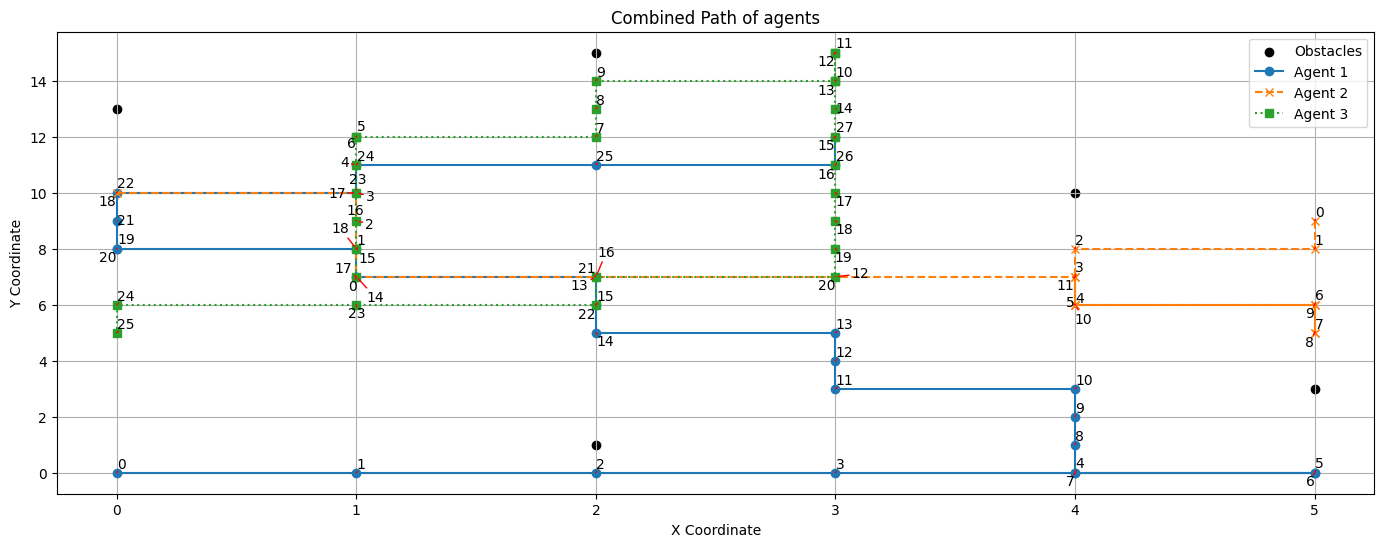

In [ ]:
# plotting path of all agent in one frame
#NOTE: the numbers at (x, y) position shows the time at which the each agent is at (x, y) location
plot_all(final_path, obstacle,  m, n)

## Case 2:

In [ ]:
# Initializing
m, n, k, obs = initialize(6, 17, 2, 5)

# Create an empty list to store constraints
constraint_list = []

In [ ]:
# Defining the starting points, obstacle, pick up location, drop location, destination for the given case
obstacle = [(0, 13), (2, 1), (2, 15), (4, 10), (5, 3)]

# each column represent the number of robots/agents
start = [(0, 0), (5, 9)]
pick = [(5, 0), (1, 12)]
drop = [(0, 8), (5, 5)]
desti = [(3, 12), (0, 5)]

print(f"start: {start}\npick: {pick}\ndrop: {drop}\ndesti: {desti}\nobstacles: {obstacle}")

start: [(0, 0), (5, 9)]
pick: [(5, 0), (1, 12)]
drop: [(0, 8), (5, 5)]
desti: [(3, 12), (0, 5)]
obstacles: [(0, 13), (2, 1), (2, 15), (4, 10), (5, 3)]


In [ ]:
# find path from start from start ------> pick up location ---->  drop locationn ------> destination
final_path = find_path_using_CBS(start, pick, drop, desti)

# printing the path
print(f'Path for Agent 1:{final_path[0]}')
print(f'Path for Agent 2:{final_path[1]}')

Path for Agent 1:[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 0), (4, 0), (4, 1), (4, 2), (4, 3), (3, 3), (3, 4), (3, 5), (2, 5), (2, 6), (2, 7), (1, 7), (1, 8), (0, 8), (0, 8), (0, 9), (0, 10), (1, 10), (2, 10), (3, 10), (3, 11), (3, 12)]
Path for Agent 2:[(5, 9), (4, 9), (3, 9), (3, 10), (3, 11), (2, 11), (2, 12), (1, 12), (1, 12), (1, 11), (1, 10), (1, 9), (2, 9), (3, 9), (3, 8), (4, 8), (4, 7), (4, 6), (5, 6), (5, 5), (5, 5), (4, 5), (3, 5), (2, 5), (1, 5), (0, 5)]


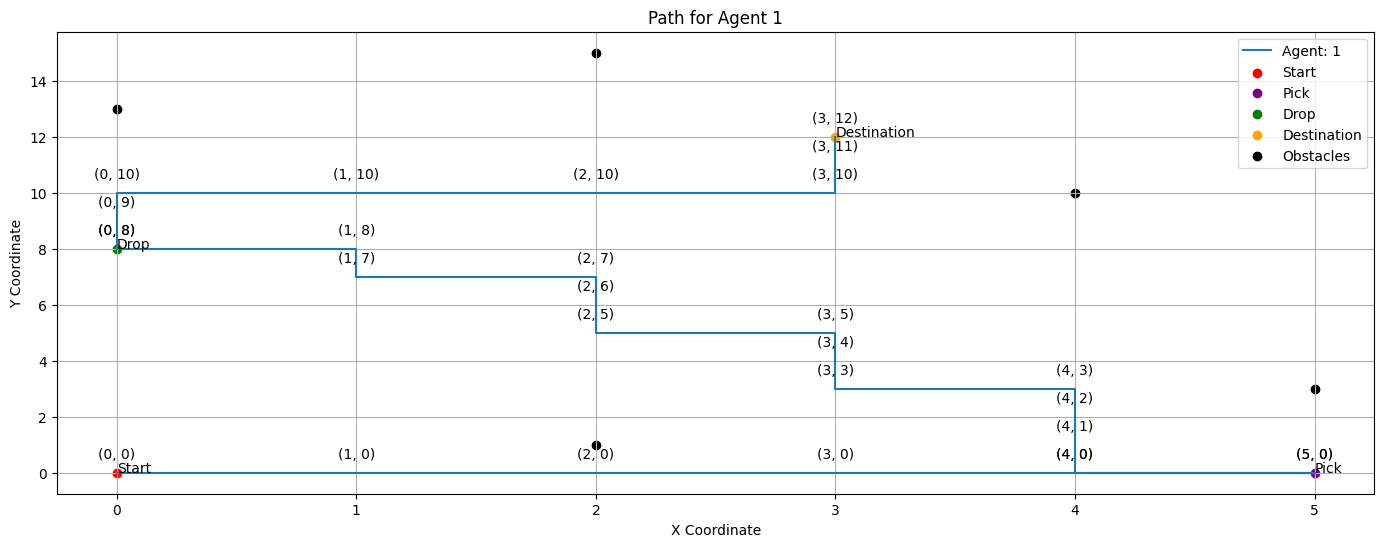

In [ ]:
# Path of Agent 1
plot_path(final_path[0], [start[0], pick[0], drop[0], desti[0]], obstacle, 1, m, n)

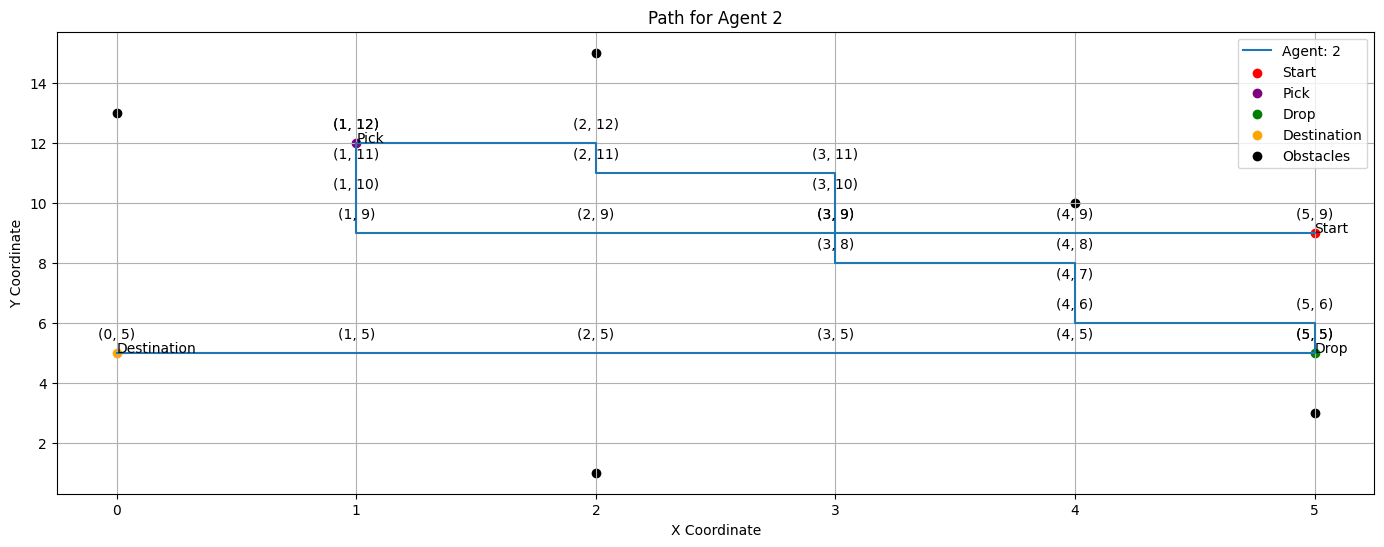

In [ ]:
# Path of Agent 2
plot_path(final_path[1], [start[1], pick[1], drop[1], desti[1]], obstacle, 2, m, n)

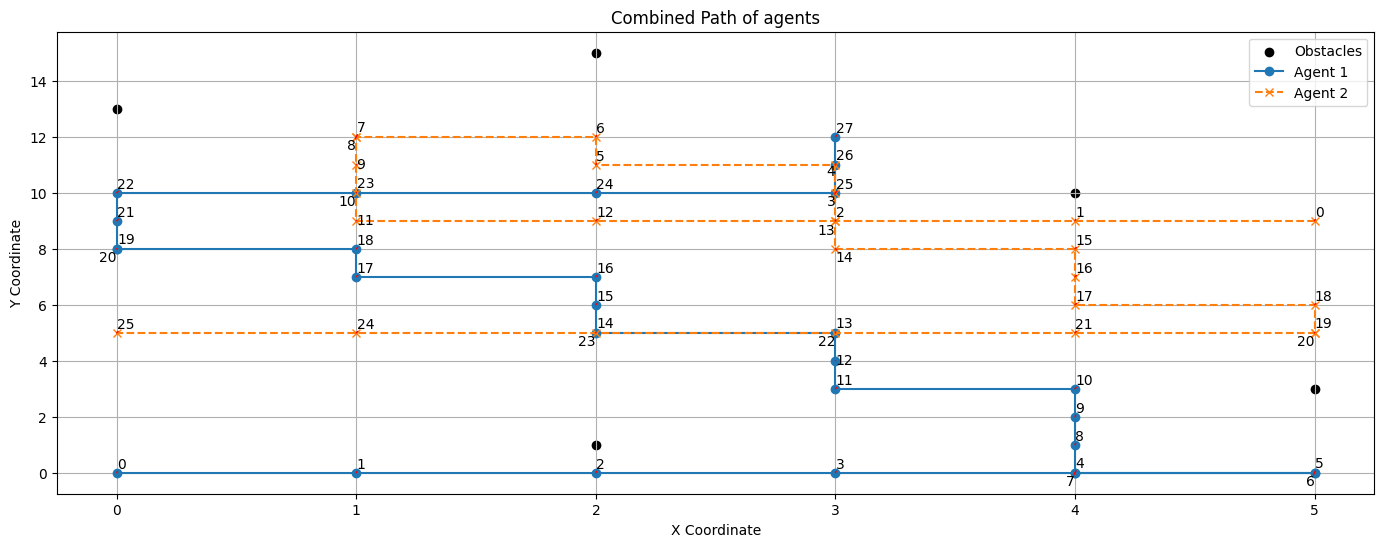

In [ ]:
# plotting path of all agent in one frame
#NOTE: the numbers at (x, y) position shows the time at which the each agent is at (x, y) location
plot_all(final_path, obstacle, m, n)

## Case 3:

In [ ]:
# Initializing
m, n, k, obs = initialize(5, 15, 2, 5)

# Create an empty list to store constraints
constraint_list = []

In [ ]:
# Defining the starting points, obstacle, pick up location, drop location, destination for the given case
obstacle = [(0, 13), (2, 1), (2, 14), (4, 10), (4, 3)]

# each column represent the number of robots/agents
start = [(1, 1), (1, 9)]
pick = [(3, 0), (1, 8)]
drop = [(0, 8), (2, 5)]
desti = [(4, 9), (4, 1)]

print(f"start: {start}\npick: {pick}\ndrop: {drop}\ndesti: {desti}\nobstacles: {obstacle}")

start: [(1, 1), (1, 9)]
pick: [(3, 0), (1, 8)]
drop: [(0, 8), (2, 5)]
desti: [(4, 9), (4, 1)]
obstacles: [(0, 13), (2, 1), (2, 14), (4, 10), (4, 3)]


In [ ]:
# find path from start from start ------> pick up location ---->  drop locationn ------> destination
final_path = find_path_using_CBS(start, pick, drop, desti)

# printing the final path
print(f'Path for Agent 1:{final_path[0]}')
print(f'Path for Agent 2:{final_path[1]}')

Path for Agent 1:[(1, 1), (1, 0), (2, 0), (3, 0), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (2, 6), (2, 7), (1, 7), (0, 7), (0, 8), (0, 8), (1, 8), (2, 8), (3, 8), (4, 8), (4, 9)]
Path for Agent 2:[(1, 9), (1, 8), (1, 8), (1, 7), (1, 6), (2, 6), (2, 5), (2, 5), (2, 4), (2, 3), (3, 3), (3, 2), (4, 2), (4, 1)]


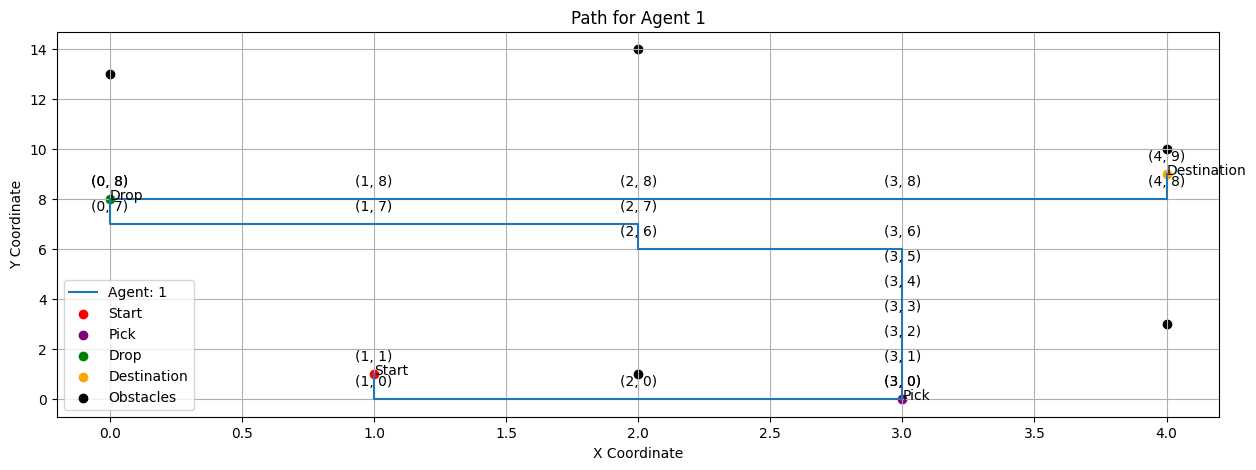

In [ ]:
# Path of Agent 1
plot_path(final_path[0], [start[0], pick[0], drop[0], desti[0]], obstacle, 1, m, n)

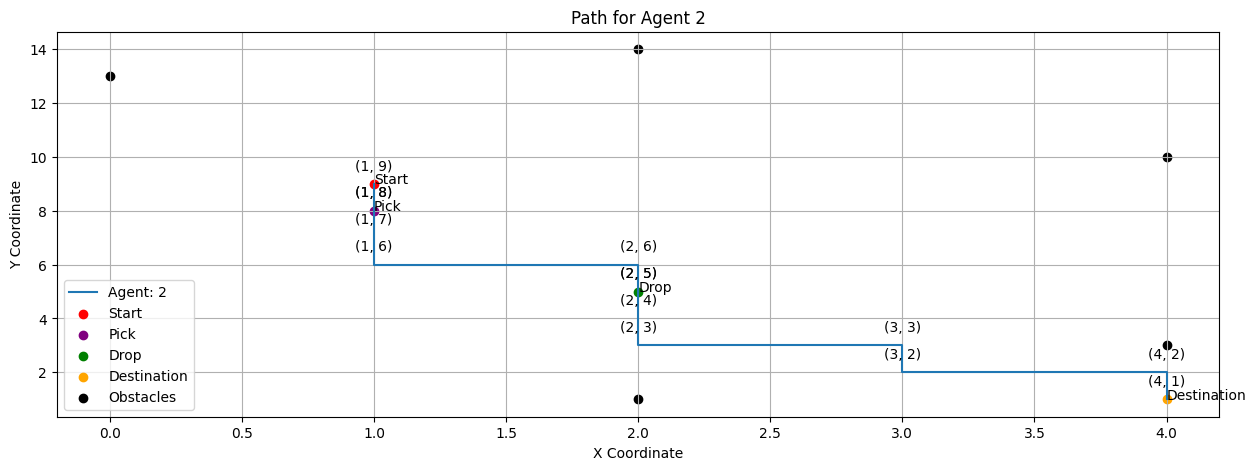

In [ ]:
# Path of Agent 2
plot_path(final_path[1], [start[1], pick[1], drop[1], desti[1]], obstacle, 2, m, n)

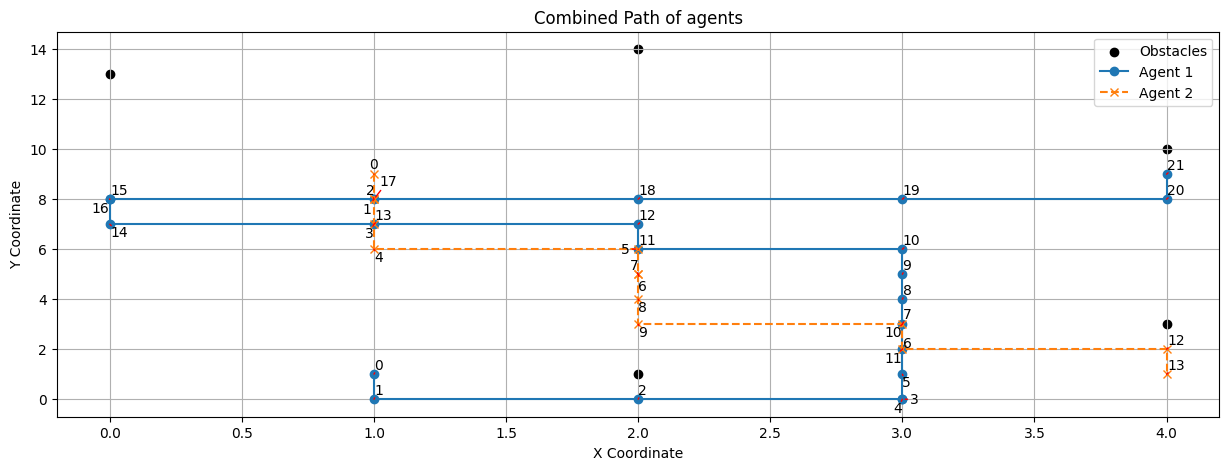

In [ ]:
# plotting path of all agent in one frame
#NOTE: the numbers at (x, y) position shows the time at which the each agent is at (x, y) location
plot_all(final_path, obstacle, m, n)

# Comparision time overheads of the CBS and A*lgorithm

### A* Algo

In [ ]:
# find path from start to destination
def find_path_A_star(start, desti):
    occupied_node = set() # (_, v, t) node v is occupied at time t

    # Initialize an empty list to store paths
    agent_path = []

    # Iterate over pairs of start and destination points
    for strt, goal in zip(start, desti):
        sub_path = search(strt, goal, '_', occupied_node)  # Find a path from 'strt' to 'goal'

        agent_path.append(sub_path)  # Append the sub-path to the path list

        for idx, ele in enumerate(sub_path):
            occupied_node.add((idx, ele, idx))

    return agent_path  # Return the list of paths

In [ ]:
# function to finding  the path using A* Agorithm
def find_path_using_A_star(start, pick, drop, desti):
    # calling the A* for finding the best path
    # start ------> pick up location ---------> drop location --------> Destionation
    start_pick = find_path_A_star(start, pick)
    pick_drop = find_path_A_star(pick, drop)
    drop_desti = find_path_A_star(drop, desti)

    # Merging all the route into one
    final_path = []

    for i in range(k):
        path = []
        path.extend(start_pick[i])
        path.extend(pick_drop[i])
        path.extend(drop_desti[i])

        final_path.append(path)

    return final_path

## Case 1: For the given case

In [ ]:
# Initializing
m, n, k, obs = initialize(6, 17, 3, 5)

# Create an empty list to store constraints
constraint_list = []

In [ ]:
# Defining the starting points, obstacle, pick up location, drop location, destination for the given case
obstacle = [(0, 13), (2, 1), (2, 15), (4, 10), (5, 3)]

# each column represent the number of robots/agents
start = [(0, 0), (5, 9), (1, 7)]
pick = [(5, 0), (4, 6), (1, 12)]
drop = [(0, 8), (5, 5), (3, 15)]
desti = [(3, 12), (0, 10), (0, 5)]

print(f"start: {start}\npick: {pick}\ndrop: {drop}\ndesti: {desti}\nobstacles: {obstacle}")

start: [(0, 0), (5, 9), (1, 7)]
pick: [(5, 0), (4, 6), (1, 12)]
drop: [(0, 8), (5, 5), (3, 15)]
desti: [(3, 12), (0, 10), (0, 5)]
obstacles: [(0, 13), (2, 1), (2, 15), (4, 10), (5, 3)]


In [ ]:
import time
start_time = time.time()
final_path = find_path_using_CBS(start, pick, drop, desti)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time from using CBS Algo: {execution_time} seconds")

Execution time from using CBS Algo: 0.023203611373901367 seconds


In [ ]:
import time
start_time = time.time()
final_path = find_path_using_A_star(start, pick, drop, desti)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time from using A* Algo: {execution_time} seconds")

Execution time from using A* Algo: 0.01604628562927246 seconds
